use:  cuda


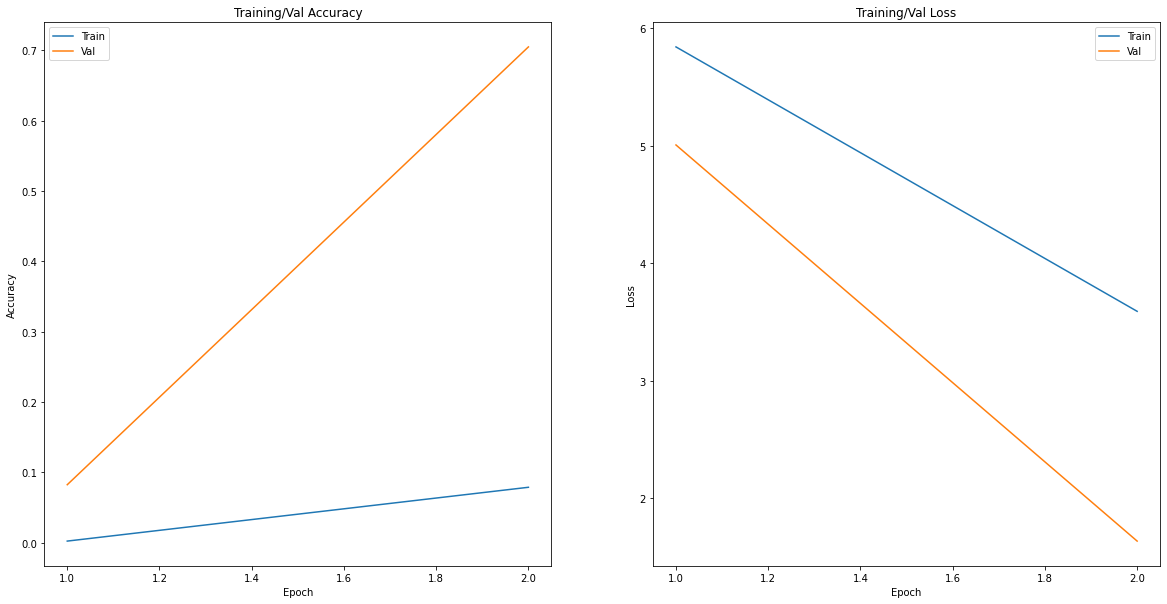

LR : 0.0002500000000000001, Batch Size : 128, 현재 Epoch : 2
Train 정확도 : 0.07889058440923691, Train Loss : 3.589700698852539
Val 정확도 : 0.7047574520111084, Val Loss : 1.6326186656951904
가장 높은 Val 정확도 : 0.7047574520111084


In [36]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from dataset import Dacon
from model import *
from PIL import Image
from tqdm.auto import tqdm, trange
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('use: ',device)

checkpoint = torch.load('vit_base.pt')
train_accuracy_list = checkpoint['train_accuracy']
train_loss_list = checkpoint['train_loss']
val_accuracy_list = checkpoint['val_accuracy']
val_loss_list = checkpoint['val_loss']
learning_rate = checkpoint['learning_rate']
batch_size = checkpoint['batch_size']

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].set_title("Training/Val Accuracy")
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Epoch")
ax[0].plot(range(1, len(train_accuracy_list)+1), train_accuracy_list)
ax[0].plot(range(1, len(val_accuracy_list)+1), val_accuracy_list)
ax[0].legend(['Train', 'Val'])
#ax[0].set_xlim(left=15)
#ax[0].set_ylim(bottom=0.8)

ax[1].set_title("Training/Val Loss")
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Epoch")
ax[1].plot(range(1, len(train_loss_list)+1), train_loss_list)
ax[1].plot(range(1, len(val_loss_list)+1), val_loss_list)
ax[1].legend(['Train', 'Val'])
#ax[1].set_xlim(left=15)
#ax[1].set_ylim(top=1.5)
plt.show()

print(f"LR : {learning_rate}, Batch Size : {batch_size}, 현재 Epoch : {checkpoint['epoch']}")
print(f"Train 정확도 : {train_accuracy_list[-1]}, Train Loss : {train_loss_list[-1]}")
print(f"Val 정확도 : {val_accuracy_list[-1]}, Val Loss : {val_loss_list[-1]}")
print(f"가장 높은 Val 정확도 : {max(val_accuracy_list)}")

In [24]:
import timm
from efficientnet_pytorch import EfficientNet
from pprint import pprint
from torchsummary import summary

name = timm.list_models("*resnext*")
pprint(name)

['cspresnext50',
 'cspresnext50_iabn',
 'ecaresnext26tn_32x4d',
 'gluon_resnext50_32x4d',
 'gluon_resnext101_32x4d',
 'gluon_resnext101_64x4d',
 'gluon_seresnext50_32x4d',
 'gluon_seresnext101_32x4d',
 'gluon_seresnext101_64x4d',
 'ig_resnext101_32x8d',
 'ig_resnext101_32x16d',
 'ig_resnext101_32x32d',
 'ig_resnext101_32x48d',
 'legacy_seresnext26_32x4d',
 'legacy_seresnext50_32x4d',
 'legacy_seresnext101_32x4d',
 'resnext50_32x4d',
 'resnext50d_32x4d',
 'resnext101_32x4d',
 'resnext101_32x8d',
 'resnext101_64x4d',
 'seresnext26_32x4d',
 'seresnext26d_32x4d',
 'seresnext26t_32x4d',
 'seresnext26tn_32x4d',
 'seresnext50_32x4d',
 'seresnext101_32x4d',
 'seresnext101_32x8d',
 'skresnext50_32x4d',
 'ssl_resnext50_32x4d',
 'ssl_resnext101_32x4d',
 'ssl_resnext101_32x8d',
 'ssl_resnext101_32x16d',
 'swsl_resnext50_32x4d',
 'swsl_resnext101_32x4d',
 'swsl_resnext101_32x8d',
 'swsl_resnext101_32x16d',
 'tv_resnext50_32x4d']


In [25]:
l = timm.create_model('skresnext50_32x4d', pretrained=True, num_classes=1049)
l.eval()
l = l.cuda()
summary(l, input_size=(3, 224, 224))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/skresnext50_ra-f40e40bf.pth" to /home/jiuk/.cache/torch/hub/checkpoints/skresnext50_ra-f40e40bf.pth
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
              ReLU-6          [-1, 128, 56, 56]               0
    BatchNormAct2d-7          [-1, 128, 56, 56]             256
         ConvBnAct-8          [-1, 128, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]           4,608
             ReLU-10          [-1, 128, 56, 56]               0
   BatchNormAct2d-11          [-1, 1

In [22]:
m = timm.create_model('vit_large_patch16_224', pretrained=True, num_classes=1049)
m.eval()
m = m.cuda()
summary(m, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 1024, 14, 14]         787,456
        PatchEmbed-2            [-1, 196, 1024]               0
           Dropout-3            [-1, 197, 1024]               0
         LayerNorm-4            [-1, 197, 1024]           2,048
            Linear-5            [-1, 197, 3072]       3,148,800
           Dropout-6         [-1, 16, 197, 197]               0
            Linear-7            [-1, 197, 1024]       1,049,600
           Dropout-8            [-1, 197, 1024]               0
         Attention-9            [-1, 197, 1024]               0
         Identity-10            [-1, 197, 1024]               0
        LayerNorm-11            [-1, 197, 1024]           2,048
           Linear-12            [-1, 197, 4096]       4,198,400
             GELU-13            [-1, 197, 4096]               0
          Dropout-14            [-1, 19

In [17]:
n = EfficientNet.from_pretrained("efficientnet-b1", num_classes=1049)
n.eval()
n = n.cuda()
summary(n, input_size=(3, 224, 224))        

Loaded pretrained weights for efficientnet-b1
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 226, 226]               0
Conv2dStaticSamePadding-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
MemoryEfficientSwish-4         [-1, 32, 112, 112]               0
         ZeroPad2d-5         [-1, 32, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 32, 112, 112]             288
       BatchNorm2d-7         [-1, 32, 112, 112]              64
MemoryEfficientSwish-8         [-1, 32, 112, 112]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13        

* EfficientNet-b1 : 7,856,953
* Vit_base_16 : 86,453,273
* Vit_base_res26d_16 : 101,374,073
* Vit_large_16 : 304,174,105
* Sk_resnext50_32x4d : 27,580,185